In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight  
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
MOOD_MAPPING = {
    0: 'sadness',
    1: 'joy', 
    2: 'love', 
    3: 'anger', 
    4: 'fear', 
    5: 'surprise'
}

In [3]:
DATA_PATH = 'Mood-Data/'  
TRAIN_FILE = 'Mood_training.csv'
TEST_FILE = 'Mood_test.csv'
VAL_FILE = 'Mood_validation.csv'

In [4]:
# Parameter untuk Tokenizer
MAX_WORDS = 10000  # Jumlah kata maksimal dalam vocabulary
MAX_LEN = 150  # Panjang maksimal sequence
PADDING_TYPE = 'post'
TRUNCATING_TYPE = 'post'
OOV_TOKEN = '<OOV>'

In [5]:
def load_data(file_path):
    """Membaca data CSV dan mengembalikan teks dan labelnya."""
    data = pd.read_csv(file_path)
    texts = data['text'].values  # Asumsi kolom teks bernama 'text'
    moods = data['label'].values  # Asumsi kolom label bernama 'mood'
    return texts, moods

X_train, y_train = load_data(DATA_PATH + TRAIN_FILE)
X_test, y_test = load_data(DATA_PATH + TEST_FILE)
X_val, y_val = load_data(DATA_PATH + VAL_FILE)

In [6]:
print(X_train, y_train)
print(X_test, y_test)
print(X_val, y_val)


['i didnt feel humiliated'
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'
 'im grabbing a minute to post i feel greedy wrong' ...
 'i feel strong and good overall'
 'i feel like this was such a rude comment and im glad that t'
 'i know a lot but i feel so stupid because i can not portray it'] [0 0 3 ... 1 3 0]
['im feeling rather rotten so im not very ambitious right now'
 'im updating my blog because i feel shitty'
 'i never make her separate from me because i don t ever want her to feel like i m ashamed with her'
 ...
 'i feel that i am useful to my people and that gives me a great feeling of achievement'
 'im feeling more comfortable with derby i feel as though i can start to step out my shell'
 'i feel all weird when i have to meet w people i text but like dont talk face to face w'] [0 0 0 ... 1 1 4]
['im feeling quite sad and sorry for myself but ill snap out of it soon'
 'i feel like i am still looking at a blank ca

In [7]:
# One hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_onehot = encoder.transform(y_val.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

In [8]:
# Tokenisasi dan Padding
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_LEN, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)

X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_val_padded = pad_sequences(X_val_sequences, maxlen=MAX_LEN, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)

X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_LEN, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)


In [9]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

In [10]:
def create_mood_detection_model(vocab_size, max_len, num_classes):
    model = Sequential([
        tf.keras.layers.Input(shape=(max_len,), dtype='int32'),  # Pastikan dtype int32
        Embedding(vocab_size, 128, input_length=max_len),
        Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.4),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [11]:
# Instansiasi Model
vocab_size = len(tokenizer.word_index) + 1
num_classes = len(MOOD_MAPPING)
model = create_mood_detection_model(vocab_size, MAX_LEN, num_classes)

c:\Users\M S I\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [12]:
# **Step 4: Training**
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train_padded, y_train_onehot,
    validation_data=(X_val_padded, y_val_onehot),
    epochs=30,
    batch_size=64, 
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 93s 358ms/step - accuracy: 0.3235 - loss: 1.8255 - val_accuracy: 0.3520 - val_loss: 1.6541
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 95s 382ms/step - accuracy: 0.3886 - loss: 1.5119 - val_accuracy: 0.7215 - val_loss: 0.7683
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 94s 374ms/step - accuracy: 0.7520 - loss: 0.6777 - val_accuracy: 0.8735 - val_loss: 0.4394
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 91s 365ms/step - accuracy: 0.8907 - loss: 0.3817 - val_accuracy: 0.8930 - val_loss: 0.3535
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 91s 366ms/step - accuracy: 0.9299 - loss: 0.2775 - val_accuracy: 0.9045 - val_loss: 0.3340
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 346ms/step - accuracy: 0.9429 - loss: 0.2298 - val_accuracy: 0.9095 - val_loss: 0.3218
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 78s 312ms/step - accuracy: 0.9552 - loss: 0.1964 - val_accuracy: 0.9160 - val_loss: 0.2966
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 89s 355ms/step - accuracy: 0.9638 - loss: 0

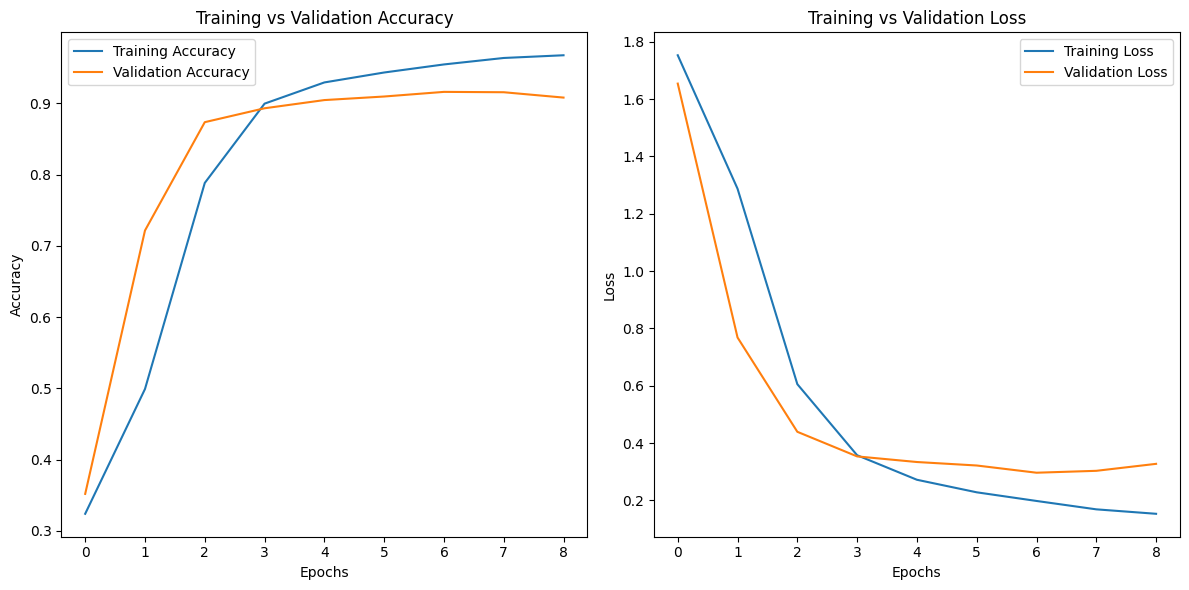

In [13]:
# **Step 6: Plot Training History**
def plot_history(history):
    """Mem-plot grafik training dan validation loss/accuracy."""
    # Plotting Accuracy
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk mem-plot hasil training
plot_history(history)


In [14]:
# Prediksi pada data uji
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_onehot, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step


In [15]:
# Laporan evaluasi
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=list(MOOD_MAPPING.values())))


Classification Report:
              precision    recall  f1-score   support

     sadness       0.98      0.96      0.97       581
         joy       0.96      0.93      0.94       695
        love       0.71      0.85      0.77       159
       anger       0.89      0.92      0.91       275
        fear       0.85      0.92      0.89       224
    surprise       0.87      0.52      0.65        66

    accuracy                           0.92      2000
   macro avg       0.88      0.85      0.85      2000
weighted avg       0.92      0.92      0.92      2000



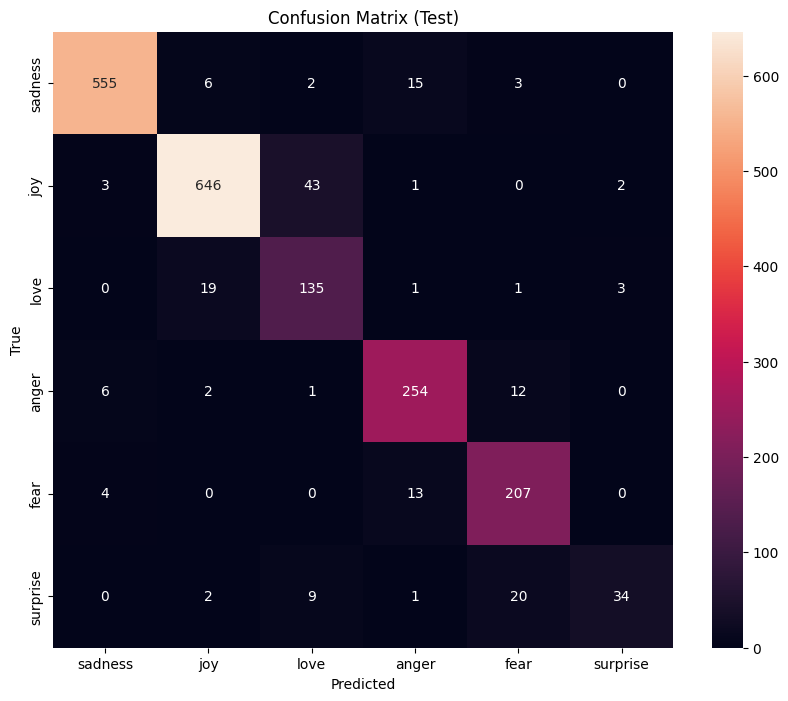

In [16]:
# Matriks kebingungan
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=list(MOOD_MAPPING.values()), yticklabels=list(MOOD_MAPPING.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test)')
plt.show()

In [17]:
# **Step 5: Evaluation**
loss, accuracy = model.evaluate(X_test_padded, y_test_onehot)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9176 - loss: 0.3087
Test Loss: 0.2875358760356903, Test Accuracy: 0.9154999852180481


In [18]:
def predict_mood(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding=PADDING_TYPE, truncating=TRUNCATING_TYPE)
    prediction = model.predict(padded)[0]
    predicted_class = np.argmax(prediction)
    mood = MOOD_MAPPING[predicted_class]
    confidence_scores = {MOOD_MAPPING[i]: round(prediction[i] * 100, 2) for i in range(len(prediction))}
    return mood, confidence_scores

In [19]:
# Contoh Prediksi
test_texts = [
    "i never make her separate from me because i don t ever want her to feel like i m ashamed with her",  # melancholy (sadness)
    "i just feel extremely comfortable with the group of people that i dont even need to hide myself",  # happiness (joy)
    "i find myself in the odd position of feeling supportive of",  # affection (love)
    "i feel just bcoz a fight we get mad to each other n u wanna make a publicity n let the world knows about our fight",  # frustration (anger)
    "i do feel insecure sometimes but who doesnt.",  # panic (fear)
    "i feel a little stunned but can t imagine what the folks who were working in the studio up until this morning are feeling",  # astonishment (surprise)
]

for text in test_texts:
    mood, scores = predict_mood(text)
    print(f"Text: {text}")
    print(f"Predicted Mood: {mood}")
    print("Confidence Scores:", scores)
    print("-" * 30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Text: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
Predicted Mood: sadness
Confidence Scores: {'sadness': 99.9, 'joy': 0.03, 'love': 0.0, 'anger': 0.06, 'fear': 0.0, 'surprise': 0.0}
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Text: i just feel extremely comfortable with the group of people that i dont even need to hide myself
Predicted Mood: joy
Confidence Scores: {'sadness': 0.07, 'joy': 97.81, 'love': 2.1, 'anger': 0.0, 'fear': 0.01, 'surprise': 0.02}
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Text: i find myself in the odd position of feeling supportive of
Predicted Mood: love
Confidence Scores: {'sadness': 0.0, 'joy': 0.92, 'love': 98.9, 'anger': 0.0, 'fear': 0.0, 'surprise': 0.18}
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Text: i feel just bcoz a fight we get mad to each other n u wanna make a publicity n let the 

In [20]:
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import json

# Simpan tokenizer ke file JSON
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer_json)
print("Tokenizer saved as tokenizer.json")


Tokenizer saved as tokenizer.json


In [21]:
import pickle

# Simpan encoder ke file PKL
with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)
print("Encoder saved as encoder.pkl")


Encoder saved as encoder.pkl


In [3]:
from tensorflow.keras.models import load_model

h5_model_path = "mood_detection_model_final.h5"
model = load_model(h5_model_path)

# Periksa ringkasan model
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (64, 150, 128)         │     1,947,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (64, 150, 256)         │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (64, 256)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (64, 128)              │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (64, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (64, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (64, 6)                │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,252,104 (8.59 MB)

 Trainable params: 2,252,102 (8.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [31]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def convert_h5_to_pb(h5_model_path, pb_model_dir):
    # Load model Keras
    model = load_model(h5_model_path)

    # Konversi input model ke float32
    input_signature = tf.TensorSpec(model.inputs[0].shape, tf.float32)
    concrete_func = tf.function(lambda x: model(x))
    concrete_func = concrete_func.get_concrete_function(input_signature)

    # Membekukan model
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    frozen_func.graph.as_graph_def()

    # Simpan sebagai file .pb
    tf.io.write_graph(
        frozen_func.graph, pb_model_dir, "frozen_model.pb", as_text=False
    )
    print(f"Model disimpan di {pb_model_dir}/frozen_model.pb")


In [32]:
for layer in model.layers:
    print(f"Layer {layer.name}: dtype={layer.dtype}")


Layer embedding_2: dtype=float32
Layer bidirectional_2: dtype=float32
Layer global_max_pooling1d_2: dtype=float32
Layer dense_6: dtype=float32
Layer dropout_4: dtype=float32
Layer dense_7: dtype=float32
Layer dropout_5: dtype=float32
Layer dense_8: dtype=float32


In [33]:
print("Model input shape:", model.input_shape)
print("Model output shape:", model.output_shape)


Model input shape: (64, 150)
Model output shape: (64, 6)


In [36]:
pb_model_dir = "saved_model_directory"
model.export(pb_model_dir)  # Simpan sebagai SavedModel
print(f"Model berhasil disimpan dalam format SavedModel di {pb_model_dir}")


INFO:tensorflow:Assets written to: saved_model_directory\assets


INFO:tensorflow:Assets written to: saved_model_directory\assets


Saved artifact at 'saved_model_directory'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  1689574867216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1689574870672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1689574872016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1689574868176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1689574871632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1689574869328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1689574869904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1689574869520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1689574870096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1689574872976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1689574873936: TensorSpec(shape=(), 